# Roman Galactic Plane Survey Region Design

In 2024, the astronomical community submitted a set of White Papers and Science Pitches regarding the science that could be done with a Roman survey of the Galactic Plane.  Many of these contributions identified numerous specific regions of interest, and preferred filters for the observations.  

In this notebook, we extract the specified regions and filter sets with the goal of combining them into single overall desired survey footprint.  

In [1]:
import config_utils
import survey_footprints
import healpy as hp
from astropy import units as u
from astropy.coordinates import Galactic, TETE, SkyCoord
import numpy as np
import matplotlib.pyplot as plt
import json
from os import path

# Configure path to local repository
root_dir = '/Users/rstreet/software/rgps'

File config/rgps_survey_regions.json contains the desired survey regions from each community contribution, described in machine-readable form.

Note that not all of the science cases specified explicit regions or filter selections.  Those that did have been marked 'ready_for_use': 'True'; further details will be sought from the authors for the remaining science cases. 

In [2]:
config = config_utils.read_config(path.join(root_dir, 'config', 'rgps_survey_regions.json'))
config

{'Paladini': {'F213': [{'l': [10.0, 60.0], 'b': [-2.5, 2.5]},
   {'l': [60.0, 10.0], 'b': [-2.5, 2.5]},
   {'l': [-10, 80.0], 'b': [-8.0, 8.0]},
   {'l': [-10.0, 30.0], 'b': [-8.0, 8.0]}],
  'comment': 'Galactic Plane Science',
  'ready_for_use': True},
 'Zari': {'F106': [{'l': [-90.0, 90.0], 'b': [-2.0, 2.0]}],
  'F158': [{'l': [-90.0, 90.0], 'b': [-2.0, 2.0]}],
  'F213': [{'l': [-90.0, 90.0], 'b': [-2.0, 2.0]}],
  'comment': 'Young Stars',
  'ready_for_use': True},
 'Kruszynska': {'F087': [{'survey_footprint': 'rubin_galactic_plane'}],
  'F213': [{'survey_footprint': 'rubin_galactic_plane'}],
  'comment': 'Galactic Plane science, Rubin synergies',
  'ready_for_use': True},
 'Benecchi': {'F146': [{'region': 'RA=289.4, DEC=-20.2, 3xWFI FOV'}],
  'comment': 'Solar System',
  'ready_for_use': False},
 'Kupfer': {'F062 and the F087': [{'region': '100sqdeg in Plane regions of high stellar density'}],
  'comment': 'High cadence; galactic binaries',
  'ready_for_use': False},
 'Elowitz': {'q

Regions of interest are specified on a per-filter basis, and replicated for multiple filters if this more than one bandpass was requested for the region.  This will be used later on to build combined survey maps for each filter.

Our next step is to extract a dictionary of the desired regions for each filter, grism and prism that Roman offers.

In [3]:
optical_components = ['F087', 'F106', 'F129', 'F158', 'F184', 'F213', 'F146', 'G150', 'P127']
requested_regions = {optic: [] for optic in optical_components}

for author, info in config.items():
    print(author, info)
    if info['ready_for_use']:
        print('Ready')
        for optic in optical_components:
            if optic in info.keys():
                for region in info[optic]:
                    requested_regions[optic].append(region)

requested_regions

Paladini {'F213': [{'l': [10.0, 60.0], 'b': [-2.5, 2.5]}, {'l': [60.0, 10.0], 'b': [-2.5, 2.5]}, {'l': [-10, 80.0], 'b': [-8.0, 8.0]}, {'l': [-10.0, 30.0], 'b': [-8.0, 8.0]}], 'comment': 'Galactic Plane Science', 'ready_for_use': True}
Ready
Zari {'F106': [{'l': [-90.0, 90.0], 'b': [-2.0, 2.0]}], 'F158': [{'l': [-90.0, 90.0], 'b': [-2.0, 2.0]}], 'F213': [{'l': [-90.0, 90.0], 'b': [-2.0, 2.0]}], 'comment': 'Young Stars', 'ready_for_use': True}
Ready
Kruszynska {'F087': [{'survey_footprint': 'rubin_galactic_plane'}], 'F213': [{'survey_footprint': 'rubin_galactic_plane'}], 'comment': 'Galactic Plane science, Rubin synergies', 'ready_for_use': True}
Ready
Benecchi {'F146': [{'region': 'RA=289.4, DEC=-20.2, 3xWFI FOV'}], 'comment': 'Solar System', 'ready_for_use': False}
Kupfer {'F062 and the F087': [{'region': '100sqdeg in Plane regions of high stellar density'}], 'comment': 'High cadence; galactic binaries', 'ready_for_use': False}
Elowitz {'questions': 'choice of filters, preference of a

{'F087': [{'survey_footprint': 'rubin_galactic_plane'}],
 'F106': [{'l': [-90.0, 90.0], 'b': [-2.0, 2.0]}],
 'F129': [{'l': [20.0, 50.0], 'b': [-1.0, 1.0]}],
 'F158': [{'l': [-90.0, 90.0], 'b': [-2.0, 2.0]},
  {'l': [20.0, 50.0], 'b': [-1.0, 1.0]},
  {'l': [-1, 1.0], 'b': [-3.0, 3.0]},
  {'l': [89.0, 91.0], 'b': [-3.0, 3.0]},
  {'l': [179.0, 181.0], 'b': [-3.0, 3.0]},
  {'l': [269.0, 271.0], 'b': [-3.0, 3.0]}],
 'F184': [{'l': [-90.0, 90.0], 'b': [-0.5, 0.5]},
  {'l': [-30.0, 30.0], 'b': [-1.0, 1.0]},
  {'l': [-10.0, 10.0], 'b': [-2.0, 2.0]}],
 'F213': [{'l': [10.0, 60.0], 'b': [-2.5, 2.5]},
  {'l': [60.0, 10.0], 'b': [-2.5, 2.5]},
  {'l': [-10, 80.0], 'b': [-8.0, 8.0]},
  {'l': [-10.0, 30.0], 'b': [-8.0, 8.0]},
  {'l': [-90.0, 90.0], 'b': [-2.0, 2.0]},
  {'survey_footprint': 'rubin_galactic_plane'},
  {'l': [20.0, 50.0], 'b': [-1.0, 1.0]},
  {'l': [-1, 1.0], 'b': [-3.0, 3.0]},
  {'l': [89.0, 91.0], 'b': [-3.0, 3.0]},
  {'l': [179.0, 181.0], 'b': [-3.0, 3.0]},
  {'l': [269.0, 271.0], '

Desired regions are defined as one of the following options:
a) a box in galactic longitude, latitude (l, b) 
b) a single pointing, in which case it is assumed that the requested region fits into the field of view of Roman's Wide Field Imager (WFI).  For the time being a fixed rectangle matching the WFI field of view is centered on the coordinates given is used for these pointings.  
c) a pre-defined HEALpixel map.  This option is most commonly used for synergies with other surveys. 

The next step is to convert these regions into HEALpixels using the following class, so we first load the set of predefined survey footprints. 

In [6]:
survey_footprints = survey_footprints.load_survey_footprints(root_dir)

In [4]:
class CelestialRegion:
    """Class to describe a region on sky, including its position and
    extend in an on-sky visualization

    Note: NSIDE = 64
    """

    def __init__(self,params={}):
        self.l_center = None
        self.b_center = None
        self.l_width = None
        self.b_height = None
        self.predefined_pixels = False
        self.pixel_priority = None
        self.NSIDE = 64
        self.NPIX = hp.nside2npix(self.NSIDE)
        self.pixels = None

        for key, value in params.items():
            if key in dir(self):
                setattr(self,key,value)

        if self.l_width:
            self.halfwidth = self.l_width*u.deg / 2.0
        if self.b_height:
            self.halfheight = self.b_height*u.deg / 2.0

    def calc_ap_healpixels_for_region(self,ahp):

        if not self.predefined_pixels:
            self.skycoord = SkyCoord(self.l_center*u.deg,
                                     self.b_center*u.deg,
                                     frame=Galactic())
            self.pixels = ahp.cone_search_skycoord(self.skycoord,
                                                    self.halfwidth)

    def calc_hp_healpixels_for_circular_region(self):
        """Method calculates the HEALpixels included within the region.
        If the radius of the region is smaller than half that of the HEALpixel map
        resolution, then a minimum radius of 1 HEALpixel is imposed"""

        if not self.predefined_pixels:
            self.skycoord = SkyCoord(self.l_center*u.deg,
                                     self.b_center*u.deg,
                                     frame=Galactic())
            self.skycoord = self.skycoord.transform_to('icrs')
            phi = np.deg2rad(self.skycoord.ra.deg)
            theta = (np.pi/2.0) - np.deg2rad(self.skycoord.dec.deg)
            radius = max(np.deg2rad(self.halfwidth.data),
                         np.deg2rad(hp.max_pixrad(self.NSIDE,degrees=True)/2.0))
            xyz = hp.ang2vec(theta, phi)
            self.pixels = hp.query_disc(self.NSIDE, xyz, radius)

    def calc_hp_healpixels_for_box_region(self):
        """Method calculates the HEALpixels included within a box-shaped region.
        If the radius of the region is smaller than half that of the HEALpixel map
        resolution, then a minimum radius of 1 HEALpixel is imposed"""

        if not self.predefined_pixels:
            pixels = []
        
            l_min = self.l_center - self.halfwidth
            l_max = self.l_center + self.halfwidth
            b_min = self.b_center - self.halfheight
            b_max = self.b_center + self.halfheight
            
            for l in np.arange(l_min.value, l_max.value, 1.0):
                for b in np.arange(b_min.value, b_max.value, 1.0):
                    self.skycoord = SkyCoord(l, b, frame=Galactic(), unit=(u.deg, u.deg))
            
                    self.skycoord = self.skycoord.transform_to('icrs')
                    phi = np.deg2rad(self.skycoord.ra.deg)
                    theta = (np.pi/2.0) - np.deg2rad(self.skycoord.dec.deg)
                    radius = np.deg2rad(1.0)
                    xyz = hp.ang2vec(theta, phi)
                    new_pixels = hp.query_disc(self.NSIDE, xyz, radius)
                    pixels += new_pixels.tolist()
                
            self.pixels = pixels
            
    def make_map(self):
        """
        Method to create a HEALpixel array with the included pixels given a value of one and 
        zero elsewhere
        """

        self.region_map = np.zeros(self.NPIX)
        self.region_map += self.pixel_priority
        
    def summary(self):
        return 'l_center=' + str(self.l_center) + ', b_center=' + str(self.b_center) + ' n_pixels=' + str(len(self.pixels))
        

In the process of converting each region to a list of in-region HEALpixels, we also assign each pixel a value of 1.  This will be used effectively like a 'vote' for that pixel when the regions are combined later. 

In [10]:
desired_regions = {}

for optic, region_list in requested_regions.items():
    regions = []
    for box in region_list:
        # Handle box regions
        if 'l' in box.keys() and 'b' in box.keys():
            # Create a CelestialRegion object for each desired region
            lspan = box['l'][1] - box['l'][0]
            bspan = box['b'][1] - box['b'][0]
            params = {
                'l_center': (box['l'][0] + lspan/2.0)*u.deg, 
                'b_center': (box['b'][0] + bspan/2.0)*u.deg,
                'l_width': lspan, 
                'b_height': bspan
            }
            r = CelestialRegion(params)
    
            # Calculate which HEALpixels belong to this region.  This method creates the pixels list attribute
            r.calc_hp_healpixels_for_box_region()


        elif 'survey_footprint' in box.keys():
            r = CelestialRegion()
            r.region_map = survey_footprints[box['survey_footprint']]
            r.pixels = (np.where(r.region_map > 0.0)[0]).tolist()
            
        # If the region is valid, the list of included pixels will be non-zero. 
        # Each pixel within a region is given a value of 1 - essentially being a 'vote' for that pixel, 
        # for each science case.
        if len(r.pixels) > 0:
            r.pixel_priority = np.zeros(r.NPIX)
            r.pixel_priority[r.pixels] = 1.0
            r.predefined_pixels = True
            r.make_map()
            
            regions.append(r)
    
    desired_regions[optic] = regions

for optic, regions in desired_regions.items():
    if len(regions) > 0:
        print(optic + ' has region(s):')
        for r in regions:
            print(r.summary())
    else:
        print(optic + ' has no requested regions')

F087 has region(s):
l_center=None, b_center=None n_pixels=1768
F106 has region(s):
l_center=0.0 deg, b_center=0.0 deg n_pixels=2703
F129 has region(s):
l_center=35.0 deg, b_center=0.0 deg n_pixels=222
F158 has region(s):
l_center=0.0 deg, b_center=0.0 deg n_pixels=2703
l_center=35.0 deg, b_center=0.0 deg n_pixels=222
l_center=0.0 deg, b_center=0.0 deg n_pixels=46
l_center=90.0 deg, b_center=0.0 deg n_pixels=44
l_center=180.0 deg, b_center=0.0 deg n_pixels=45
l_center=270.0 deg, b_center=0.0 deg n_pixels=46
F184 has region(s):
l_center=0.0 deg, b_center=0.0 deg n_pixels=679
l_center=0.0 deg, b_center=0.0 deg n_pixels=461
l_center=0.0 deg, b_center=0.0 deg n_pixels=304
F213 has region(s):
l_center=35.0 deg, b_center=0.0 deg n_pixels=945
l_center=35.0 deg, b_center=0.0 deg n_pixels=5387
l_center=10.0 deg, b_center=0.0 deg n_pixels=2403
l_center=0.0 deg, b_center=0.0 deg n_pixels=2703
l_center=None, b_center=None n_pixels=1768
l_center=35.0 deg, b_center=0.0 deg n_pixels=222
l_center=0.0 d

Let's inspect an example region map, for illustration

/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_30788/4001297767.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1000x1000 with 0 Axes>

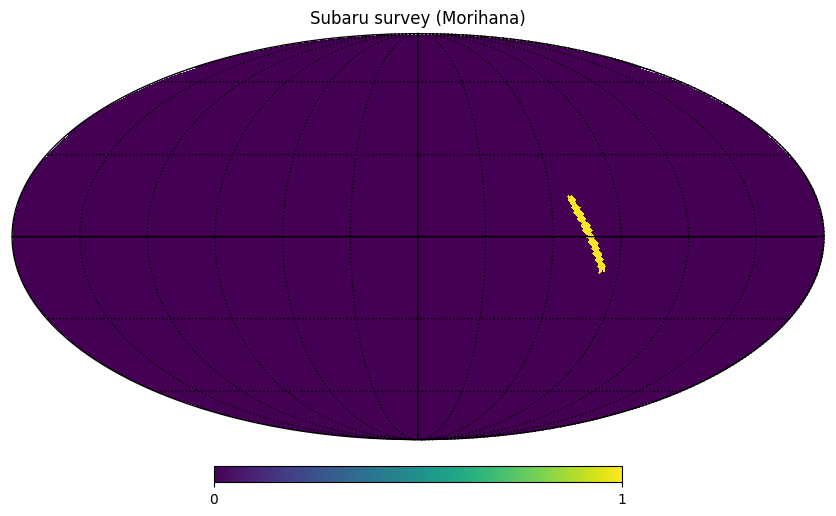

In [11]:
# Random example is the Morihana Science Pitch for synergies with the Subaru survey area
map = desired_regions['F129'][0].region_map
map_title = 'Subaru survey (Morihana)'

fig = plt.figure(3,(10,10))
hp.mollview(map, title=map_title)
hp.graticule()
plt.tight_layout()

## Building a combined survey region

With our set of desired survey regions now defined, we can combine them to form the overall survey region. 
Since all selected HEALpixels have a value of 1.0 and zero elsewhere, we can just co-add the region maps for each filter, to see which sky regions are highest priority.  

/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_30788/2069132646.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


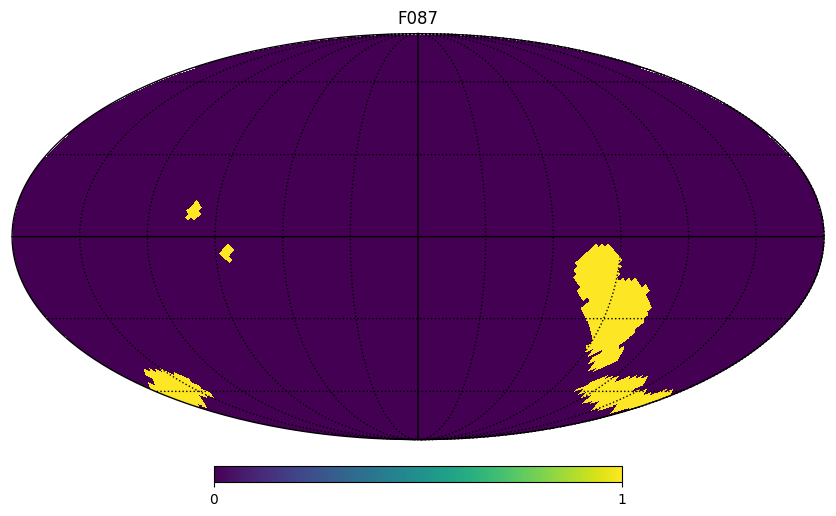

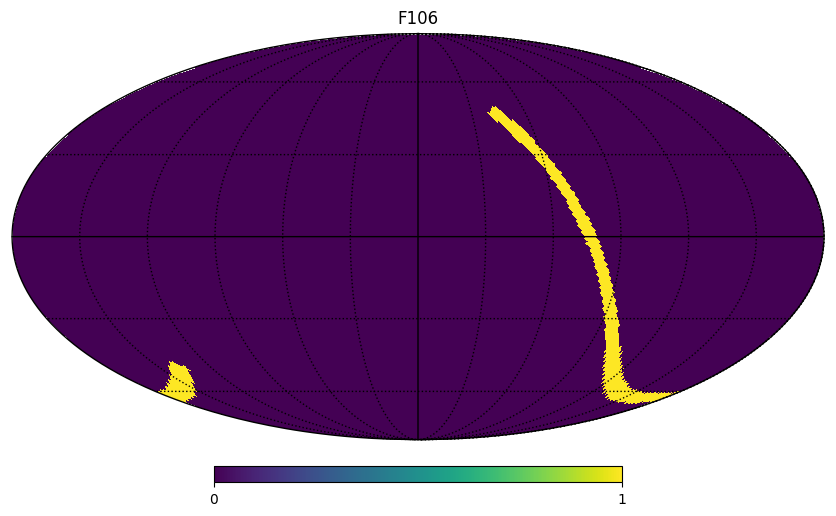

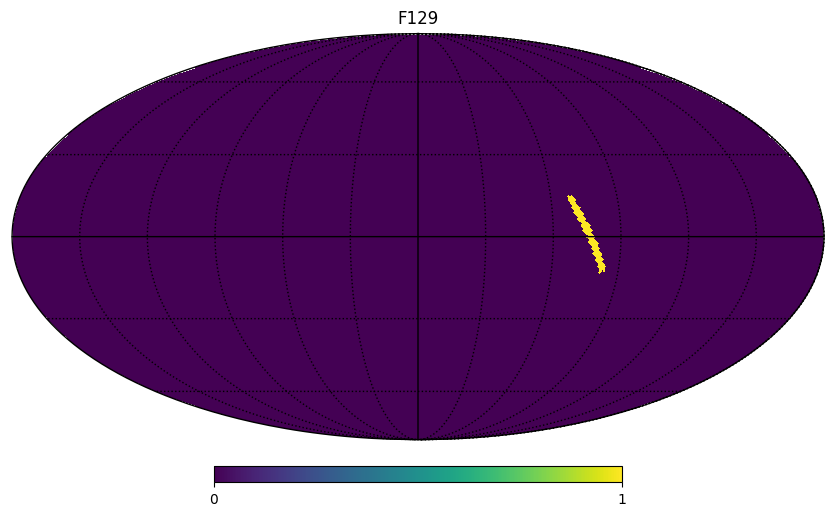

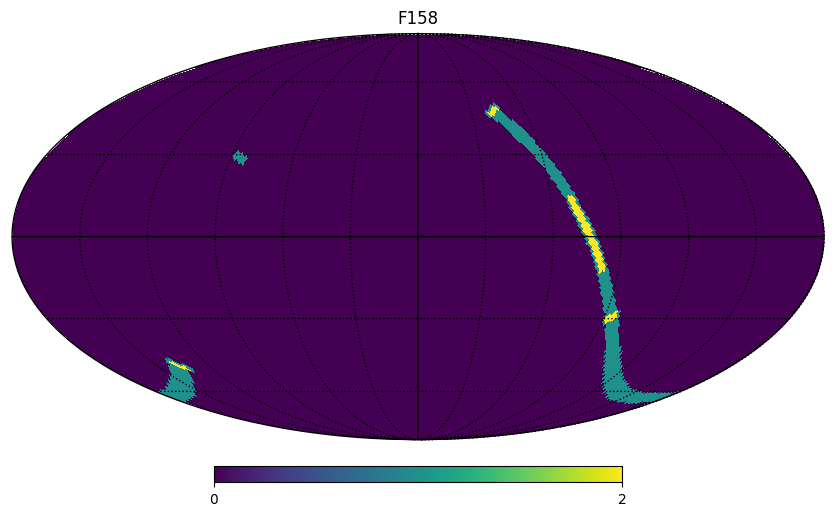

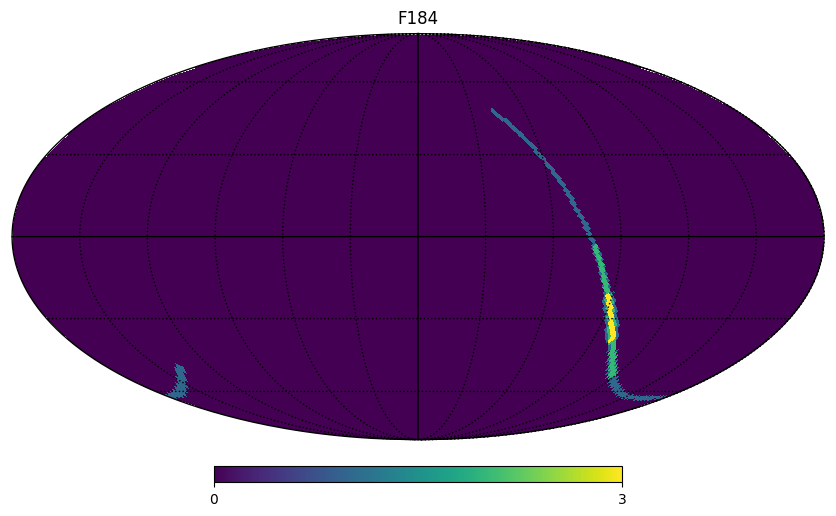

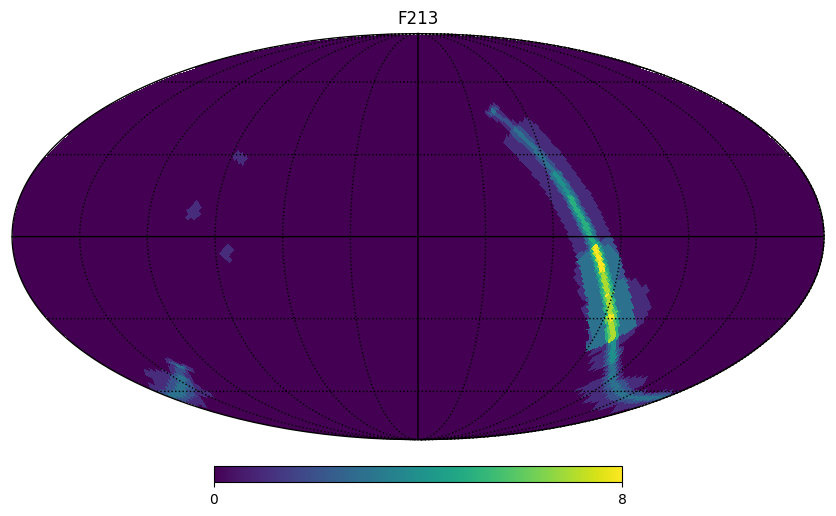

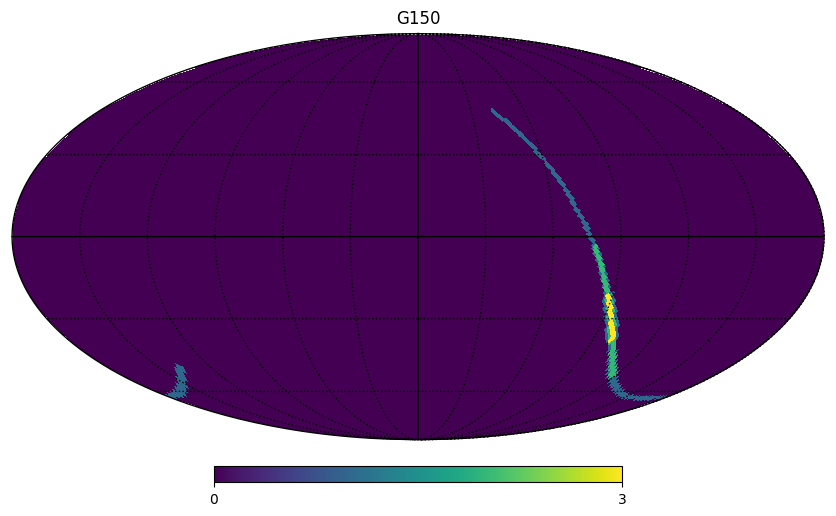

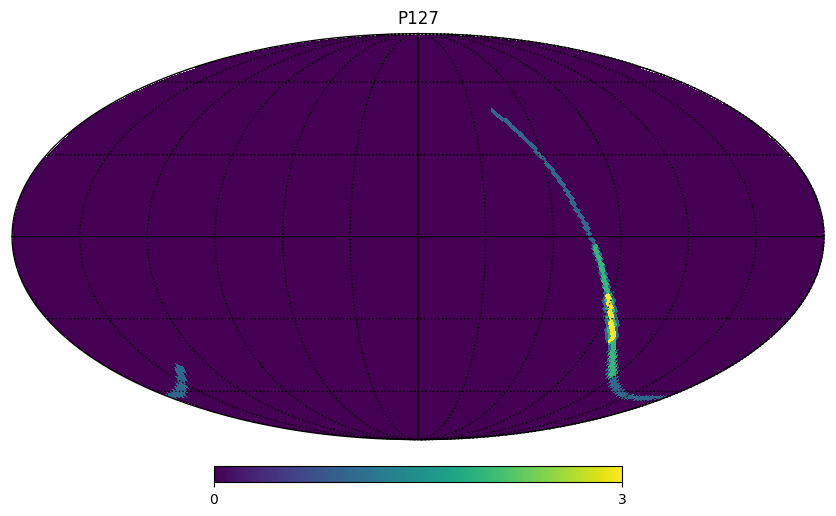

In [12]:
# Dictionary of the combined survey regions per optical component
survey_regions = {}

for optic, regions in desired_regions.items():
    if len(regions) > 0:
        map = np.zeros(CelestialRegion().NPIX)
        for r in regions:
            map += r.region_map
    
        survey_regions[optic] = map
    
        hp.mollview(map, title=optic)
        hp.graticule()
        plt.tight_layout()